# DynoRRT

DynoRRT is a C++/Python library for sampling-based motion planning (e.g., Rapidly Exploring Random Trees (RRT), Probabilistic Roadmaps (PRM), etc.)

It delivers state-of-the-art performance with an easy-to-use and install Python interface. The installation is straightforward: no ROS, no system-wide packages, no MOVEIT, no OMPL; just a simple `pip install`. Plus, it's much faster than OMPL.

With DynoRRT, you can write a motion planning problem in 60 seconds and solve it in milliseconds. Planning problems can be defined using URDF Files. We rely on Pinocchio and HPP-FCL for computing collisions and forward kinematics. These are linked statically, so you don't need them at runtime—or it's fine if you have another version of these libraries.

The Python package is created using pybind11, and the API is very similar to the C++ interface. Additionally, the Python package provides a couple of utilities to visualize the problems using Pinocchio and Meshcat, but you're free to use any viewer you want.

The library is currently in its alpha state. We are targeting a public release of version 0.1 in January. The C++ packaging is still under development. Feel free to open a GitHub issue or pull request! Special help is needed for Mac support :)

In [ ]:
# Install -- Uncomment if you want to install packages
#!pip3 install pydynorrt
#!pip3 install numpy
#!pip3 install matplotlib # For visualization of 2D problems
#!pip3 install pin # Only if you want to use Pinocchio for visualization
#!pip3 install meshcat # Only if you want to use Pinocchio for visualization

In [ ]:
# Important Notes
#
# Note 1: In Colab, you have to uninstall the package pathlib
#
#!pip3 uninstall -y pathlib
#
# Note 2: To get pinocchio working, you have to restart the session/kernel.
#

In [1]:
# Import all packages
from meshcat.animation import Animation
import numpy as np
import pydynorrt as pyrrt
from pydynorrt import pin_more as pyrrt_vis # Small utility functions to visualize motion planning
import pinocchio as pin  # Not needed in the current script (consider removing if not used)
import meshcat
import time
import matplotlib.pyplot as plt

In [2]:
# Define a planning problem
# We are going to plan a motion for a payload carried by two drones.
# The state space is 7D: 3D positions of the payload, and two angles to describe the orientation of each cable.
# We are doing "geometric" planning, ignoring the dynamical constraints and the orientation of the robots.

# Start and Goal
start = np.array([-0.62831853, 0.0, 0.0, 0.0, 0.9424778, 0.0, -0.9424778])
goal = np.array([0.62831853, 0.2, 0.3, 0.0, 0.9424778, 0.0, -0.9424778])

# State Bounds
lb = np.array([-1, -1, -1, -1.5708, -1.5708, -1.5708, -1.5708])
ub = np.array([1, 1, 1, 1.5708, 1.5708, 1.5708, 1.5708])

# We need a robot and an environment. You can define
# everything in a single URDF (currently supported) or in
# two URDFs (support for this will be available soon).
urdf = pyrrt.DATADIR + "models/point_payload_two_robots.urdf"

# Indicate which contact pairs should be ignored (e.g., usually consecutive links)
srdf = pyrrt.DATADIR + "models/point_payload_two_robots.srdf"

In [7]:
# Collision checking using the URDF model.
# Adding your custom collision checking in Python is also possible! (see below)
# Coming Soon: Parallel collision checking.
cm = pyrrt.Collision_manager_pinocchio()
cm.set_urdf_filename(urdf)
cm.set_srdf_filename(srdf)
cm.build()

# We can double-check that the start and goal are collision-free!
assert cm.is_collision_free(start)
assert cm.is_collision_free(goal)
mid = (goal + start) / 2.0
assert not cm.is_collision_free(mid)
cm.reset_counters()


Time for 1 collision check: 7.26938247680664e-07


In [9]:
# Let's visualize the problem!
# You can use your favorite library to visualize a URDF.
# In this example, we use Pinocchio and Meshcat.

# They are great. I strongly recommend checking
# all the examples and tests in the Pinocchio source code
# and the tutorials at https://github.com/Gepetto/supaero2022
viewer = meshcat.Visualizer()
viewer_helper = pyrrt_vis.ViewerHelperRRT(viewer, urdf, srdf, start, goal)
# TODO: I need to solve the issue with 
# Now, you can open the URL with your browser, in another tab, or use
viewer.render_static()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
/home/quim/miniconda3/envs/cmim/lib/python3.12/site-packages/pydynorrt/data/models/point_payload_two_robots.srdf


AttributeError: 'MeshcatVisualizer' object has no attribute 'display_frames'

In [10]:
# Create the Planner.
# PlannerRRT_Rn is an RRT planner for the space R^n, where n is given at runtime.
# E.g., RRT_R2() (TODO) knows the state space at compile time,
# which means faster memory allocation and nearest neighbor queries
# (but note that runtime is often dominated by collision checking).

# For the state space, we currently support any combination and composition of
# SO(3), R^n, SO(2), and time (see below for planning in R3 x SO(3)).

# Sample-Based Motion Planning algorithms are stochastic.
# You can fix the random seed for repeatable results with
# pyrrt.srand(1)  # use the integer you want!
rrt = pyrrt.PlannerRRT_Rn()
rrt.set_start(start)
rrt.set_goal(goal)
rrt.init(7)
rrt.set_is_collision_free_fun_from_manager(cm)
rrt.set_bounds_to_state(lb, ub)

# Options are provided through config files/strings in TOML format.
# If an option is not present, we use the default value.
config_string = """
[RRT_options]
max_it = 20000
max_num_configs = 20000
max_step = 1.0
goal_tolerance = 0.001
collision_resolution = 0.05
goal_bias = 0.1
store_all = false
"""
# rrt.read_cfg_file(my_config_file) # You can also
# provide the name of a config file.
rrt.read_cfg_string(config_string)

# Let's plan -- it is fast.

tic = time.time()
out = rrt.plan()
toc = time.time()
print("Planning Time [s]:", toc - tic)

assert out == pyrrt.TerminationCondition.GOAL_REACHED

parents = rrt.get_parents()
configs = rrt.get_configs()
path = rrt.get_path()
fine_path = rrt.get_fine_path(.05)

# Some Planners will output a lot of information useful for visualization
# and debugging -- see below. You can get this directly in a dictionary.
# (path, parents, configs) are also available as planner data.
# Planner data is a Python dictionary of plain types.
planner_data = rrt.get_planner_data()

Planning Time [s]: 0.0019257068634033203
Options 
k_near = -1
max_num_trials_col_free = 1000
max_num_configs = 20000
store_all = false
max_compute_time_ms = 1e+09
max_step = 1.0
collision_resolution = 0.05
goal_tolerance = 0.001
goal_bias = 0.1
debug = false
max_it = 20000

State Space: Rn RuntimeDIM: 7 CompileTimeDIM: -1
lb: [    -1,     -1,     -1, -1.571, -1.571, -1.571, -1.571]
ub: [    1,     1,     1, 1.571, 1.571, 1.571, 1.571]
Message in plan (/home/quim/code/dynoRRT/include/dynoRRT/rrt.h:226) --path found
0
Message in plan (/home/quim/code/dynoRRT/include/dynoRRT/rrt.h:303) --Output from RRT PLANNER
Terminate status: GOAL_REACHED
num_it: 93
configs.size(): 61
compute time (ms): 1
collisions time (ms): 1.55651
evaluated_edges: 93
infeasible_edges: 33
path.size(): 9
total_distance: 7.40049


In [11]:
# Now let's visualize the solution and the search of the planner.
# Recall that the system is 7D. To visualize the search tree, we plot only
# the position of the center ball (3D).
robot = viewer_helper.robot
viz = viewer_helper.viz

idx_vis_name = "point_mass"
IDX_VIS = robot.model.getFrameId(idx_vis_name)
display_count = 0  # Just to enumerate the number
# of objects we create in the visualizer.
for i, p in enumerate(parents):
    if p != -1:
        q1 = configs[i]
        q2 = configs[p]
        pyrrt_vis.display_edge(robot, q1, q2, IDX_VIS, display_count, viz, radius=0.005,
                              color=[0.2, 0.8, 0.2, 0.9])
        display_count += 1

for i in range(len(path) - 1):
    q1 = path[i]
    q2 = path[i + 1]
    pyrrt_vis.display_edge(robot, q1, q2, IDX_VIS, display_count, viz, radius=0.02,
                          color=[0.0, 0.0, 1.0, 0.5])
    display_count += 1

# Finally, we can visualize the path of the robot :)
# In standard Python, you can update the 
# visualization with:
# for p in fine_path:
#     viz.display(np.array(p))
#     time.sleep(0.01)

# You can generate an animation as follows:
# This is a small hack to generate a visualization -- please contact me if you know a better way!
anim = Animation()
__v = viewer_helper.viz.viewer
for i in range(len(fine_path)):
    with anim.at_frame(viewer, i) as frame:
        viewer_helper.viz.viewer = frame
        viz.display(fine_path[i])

viewer.set_animation(anim)
viewer_helper.viz.viewer = __v
viewer.render_static()

NameError: name 'viewer_helper' is not defined

In [12]:
# Congratulations! You have finished the first tutorial of DynoRRT.
# Now, we will showcase more robotics problems and some key features of DynoRRT.
# In our second problem, a robot manipulator (UR5) has to find a path
# to get inside a bin/shelf.

lb = np.array([-3.14, -3.14, -3.14, -3.14, -3.14, -3.14])
ub = np.array([3.14, 3.14, 3.14, 3.14, 3.14, 3.14])
start = np.array([0, -1.5, 2.1, -0.5, -0.5, 0])
goal = np.array([3.1, -1.0, 1, -0.5, -0.5, 0])

# We need a robot and an environment. You can define
# everything in a single URDF (currently supported) or in
# two URDFS (will be supported soon).
urdf = pyrrt.DATADIR + "models/ur5_robot_with_box.urdf"

# Indicate which contact pairs should be ignored (e.g., usually consecutive links).
srdf = pyrrt.DATADIR + "models/ur5_with_box.srdf"

# Collision checking using the URDF model.
# Note: we use simplified collision shapes for collision
# checking, instead of the original visual mesh.

cm = pyrrt.Collision_manager_pinocchio()
cm.set_urdf_filename(urdf)
cm.set_srdf_filename(srdf)
cm.build()

# We can double-check that start and goal are collision-free!
assert cm.is_collision_free(start)
assert cm.is_collision_free(goal)

cm.reset_counters()
N = 100
for i in range(N):
    p = start + (goal - start) * i / float(N)
    cm.is_collision_free(p)

print("Average Time of 1 collision in C++ [ms]", cm.get_time_ms() / N)
cm.reset_counters()

# We are creating another viewer. Note that the URL may be different!
# Collision shapes used for planning are shown with a translucent color.
viewer = meshcat.Visualizer()
package_dirs = pyrrt.DATADIR + "models/meshes"
viewer_helper = pyrrt_vis.ViewerHelperRRT(viewer, urdf,
                                         package_dirs=package_dirs, start=start, goal=goal)
viewer.render_static()

Average Time of 1 collision in C++ [ms] 0.0
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/
/home/quim/miniconda3/envs/cmim/lib/python3.12/site-packages/pydynorrt/data/models/meshes


AttributeError: 'MeshcatVisualizer' object has no attribute 'display_frames'

In [13]:
# We have implemented the most commonly used algorithms for
# sample-based motion planning: RRT, RRT*, RRTConnect, (lazy)PRM(*)...
# RRT_Connect is considered one of the fastest motion planners.
# In robotic manipulation planning, because both start and goal configurations
# are often close to the obstacles, a bidirectional search is often superior.
rrt = pyrrt.PlannerRRTConnect_Rn()
rrt.set_start(start)
rrt.set_goal(goal)
rrt.init(6)

config_str = """
[RRTConnect_options]
max_it = 100000
collision_resolution = 0.05
max_step = 1.0
max_num_configs = 100000
"""
rrt.read_cfg_string(config_str)
rrt.set_is_collision_free_fun_from_manager(cm)
rrt.set_bounds_to_state(lb, ub)

tic = time.time()
out = rrt.plan()
toc = time.time()
path = rrt.get_path()
fine_path = rrt.get_fine_path(0.05)
planner_data = rrt.get_planner_data()
# Add a small sleep to give time for the std::cout inside the compiled library to appear on the screen
# before we print from Python.
time.sleep(0.001)
print("Planning Time [s]", toc - tic)
# We can examine the content of planner data
print("Fields in planner_data", [i for i in planner_data])

parents_backward = planner_data["parents_backward"]
configs_backward = [np.array(x) for x in planner_data["configs_backward"]]
parents = planner_data["parents"]
configs = [np.array(x) for x in planner_data["configs"]]

init tree
DIM: -1
runtime_dim: 6
Options
max_num_trials_col_free = 1000
max_num_configs = 100000
max_compute_time_ms = 1e+09
max_step = 1.0
collision_resolution = 0.05
goal_tolerance = 0.001
goal_bias = 0.05
backward_probability = 0.5
max_it = 100000

Terminate status: GOAL_REACHED
num_it: 86
configs.size(): 38
configs_backwared.size(): 7
compute time (ms): 3
collisions time (ms): 2.86172
evaluated_edges: 123
infeasible_edges: 0
path.size(): 14
total_distance: 12.9983
Planning Time [s] 0.003330230712890625
Fields in planner_data ['collisions_time_ms', 'configs', 'configs_backward', 'evaluated_edges', 'fine_path', 'infeasible_edges', 'invalid_edges', 'number_collision_checks', 'parents', 'parents_backward', 'path', 'planner_name', 'sample_configs', 'total_distance', 'valid_edges']


In [ ]:
# Now, let's visualize the solution and the search of the planner.
# The system is 6D. To visualize the search tree, we plot only
# the position of the end-effector.
robot = viewer_helper.robot
viz = viewer_helper.viz

idx_vis_name = "tool0"
IDX_VIS = robot.model.getFrameId(idx_vis_name)
display_count = 0  # just to enumerate the number

# We display the forward and backward trees in two different colors.
for i, p in enumerate(parents):
    if p != -1:
        q1 = configs[i]
        q2 = configs[p]
        # Pinocchio
        pyrrt_vis.display_edge(robot, q1, q2, IDX_VIS, display_count, viz, radius=0.005,
                              color=[0.2, 0.8, 0.2, 0.9])
        display_count += 1

for i, p in enumerate(parents_backward):
    if p != -1:
        q1 = configs_backward[i]
        q2 = configs_backward[p]
        # Pinocchio
        pyrrt_vis.display_edge(robot, q1, q2, IDX_VIS, display_count, viz, radius=0.005,
                              color=[0.8, 0.2, 0.2, 0.9])
        display_count += 1

for i in range(len(path) - 1):
    q1 = path[i]
    q2 = path[i + 1]
    pyrrt_vis.display_edge(robot, q1, q2, IDX_VIS, display_count, viz, radius=0.02,
                          color=[0.0, 0.0, 1.0, 0.5])
    display_count += 1

# Finally, we can visualize the path of the robot :)
# for p in fine_path:
#     viz.display(np.array(p))
#     time.sleep(0.01)

anim = Animation()
__v = viewer_helper.viz.viewer
# A small hack to generate visualization. Please contact me if you know a better way!
for i in range(len(fine_path)):
    with anim.at_frame(viewer, i) as frame:
        viewer_helper.viz.viewer = frame
        viz.display(fine_path[i])
viewer.set_animation(anim)
viewer_helper.viz.viewer = __v
viewer.render_static()


In [14]:
# Pydynorrt supports planning in any combination of R^n, SO(3), and SO(2).
# Let's solve a problem in R^3 x SO(3) (=SE(3)) with an optimal planner.

lb = np.array([-2, -2, -1, -1, -1, -1, -1])
ub = np.array([3, 2, 1, 1, 1, 1, 1])
# State is R^3 and quaternion, with the real part last
start = np.array([0, 0, 0, 0, 0, 0, 1])
goal = np.array([2, 1, 1, 0, 0, 0, 1])
urdf = pyrrt.DATADIR + "models/se3_window.urdf"
srdf = pyrrt.DATADIR + "models/se3_window.srdf"

cm = pyrrt.Collision_manager_pinocchio()
cm.set_urdf_filename(urdf)
cm.set_srdf_filename(srdf)
cm.build()
assert cm.is_collision_free(start)
assert cm.is_collision_free(goal)

# Let's use RRT star

rrt = pyrrt.PlannerRRTStar_Combined()
rrt.init(7)
rrt.set_state_space_with_string(["Rn:3", "SO3"])

rrt.set_start(start)
rrt.set_goal(goal)


config_str = """
[RRTStar_options]
max_it = 20000
goal_bias = 0.1
collision_resolution = 0.05
max_step = 1.0
max_compute_time_ms = 3e3 # One second of compute time
goal_tolerance = 0.001
max_num_configs = 20000
"""

rrt.read_cfg_string(config_str)
rrt.set_is_collision_free_fun_from_manager(cm)
rrt.set_bounds_to_state(lb, ub)
tic = time.time()
out = rrt.plan()
toc = time.time()
path = rrt.get_path()
fine_path = rrt.get_fine_path(0.05)
planner_data = rrt.get_planner_data()
# Add a small sleep to give time for the std::cout inside the compiled library to appear on the screen
# before we print from Python.
time.sleep(0.001)
print(
    "Planning Time [s] (note that we are running an asymptotically optimal planner)", toc - tic)
# We can examine the content of planner data
print("Fields in planner_data", [i for i in planner_data])

# we can display all the paths found by the planner,
# using different values of transparency.
paths = [[np.array(x) for x in path] for path in planner_data["paths"]]

viewer = meshcat.Visualizer()
viewer_helper = pyrrt_vis.ViewerHelperRRT(viewer, urdf, "", start, goal)
robot = viewer_helper.robot
viz = viewer_helper.viz

idx_vis_name = "base_link"
IDX_VIS = viewer_helper.robot.model.getFrameId(idx_vis_name)

display_count = 0  # just to enumerate the number of edges
for pp, _path in enumerate(paths[:-1]):
    transparency = (pp+1) / (len(paths))
    for i in range(len(_path) - 1):
        q1 = _path[i]
        q2 = _path[i + 1]
        pyrrt_vis.display_edge(robot, q1, q2, IDX_VIS, display_count, viz, radius=0.02,
                                    color=[0.1, 0.1, 0.1, 0.8 * transparency])
        display_count += 1

# Best path in Blue
for i in range(len(path) - 1):
    q1 = path[i]
    q2 = path[i + 1]
    pyrrt_vis.display_edge(robot, q1, q2, IDX_VIS, display_count, viz, radius=0.02,
                          color=[0.0, 0.0, 1.0, 0.5])
    display_count += 1

anim = Animation()
__v = viewer_helper.viz.viewer
# A small hack to generate visualization. Please contact me if you know a better way!
for i in range(len(fine_path)):
    with anim.at_frame(viewer, i) as frame:
        viewer_helper.viz.viewer = frame
        viz.display(fine_path[i])

# Finally, let's display the best trajectory (the last one)
viewer.set_animation(anim)
viewer_helper.viz.viewer = __v
viewer.render_static()

out 3
Options
k_near = -1
max_num_trials_col_free = 1000
max_num_configs = 20000
store_all = false
max_compute_time_ms = 3000.0
max_step = 1.0
collision_resolution = 0.05
goal_tolerance = 0.001
goal_bias = 0.1
debug = false
max_it = 20000

informed_rrt_star: 1
Message in plan (/home/quim/code/dynoRRT/include/dynoRRT/rrtstar.h:375) --First Path Found
Message in plan (/home/quim/code/dynoRRT/include/dynoRRT/rrtstar.h:376) --Goal id: 2919
Message in plan (/home/quim/code/dynoRRT/include/dynoRRT/rrtstar.h:464) --New Path Found! Number paths 1
Message in plan (/home/quim/code/dynoRRT/include/dynoRRT/rrtstar.h:464) --New Path Found! Number paths 2
Message in plan (/home/quim/code/dynoRRT/include/dynoRRT/rrtstar.h:464) --New Path Found! Number paths 3
Message in plan (/home/quim/code/dynoRRT/include/dynoRRT/rrtstar.h:464) --New Path Found! Number paths 4
Message in plan (/home/quim/code/dynoRRT/include/dynoRRT/rrtstar.h:464) --New Path Found! Number paths 5
Message in plan (/home/quim/code/dy

AttributeError: 'MeshcatVisualizer' object has no attribute 'display_frames'

In [16]:
# In the last example, we are going to solve a problem
# with two robot arms, planning in joint space.

lb = np.array([-3.14, -3.14, -3.14, -3.14, -3.14,
               -3.14, -3.14, -3.14, -3.14, -3.14, -3.14, -3.14])

ub = np.array([3.14, 3.14, 3.14, 3.14, 3.14, 3.14, 3.14, 3.14, 3.14,
               3.14, 3.14, 3.14])

start = np.array([1.88495559, -0.9424778, 1.88495559, 0.0, 0.0,
                  0.0, -0.9424778, -0.9424778, 1.57079633, 0.0, 0.0, 0.0])

goal = np.array([0.62831853, -1.25663707, 1.88495559, 0.0, 0.0, 0.0,
                 -2.82743339, -0.9424778, 1.57079633, 0.0, 0.0, 0.0])

urdf = pyrrt.DATADIR + "models/ur5_two_robots.urdf"
srdf = pyrrt.DATADIR + "models/ur5_two_robots.srdf"

cm = pyrrt.Collision_manager_pinocchio()
cm.set_urdf_filename(urdf)
cm.set_srdf_filename(srdf)
cm.build()
assert cm.is_collision_free(start)
assert cm.is_collision_free(goal)

package_dirs = pyrrt.DATADIR + "models/meshes"
viewer = meshcat.Visualizer()
viewer_helper = pyrrt_vis.ViewerHelperRRT(
    viewer, urdf, package_dirs, start, goal)
robot = viewer_helper.robot
viz = viewer_helper.viz
idx_vis_name = "tool0"
idx_vis_name2 = "tool0ROBOT2"

IDX_VIS = robot.model.getFrameId(idx_vis_name)
IDX_VIS2 = robot.model.getFrameId(idx_vis_name2)


viewer.render_static()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/
/home/quim/miniconda3/envs/cmim/lib/python3.12/site-packages/pydynorrt/data/models/meshes


AttributeError: 'MeshcatVisualizer' object has no attribute 'display_frames'

In [17]:
# Let's solve it with LazyPRM --
# The number of nodes in the roadmap is fixed; in the next release, we will add a batch of samples incrementally.

config_str = """
[LazyPRM_options]
connection_radius = 3.5
k_near = 10
num_vertices_0 = 2000
collision_resolution = 0.05
"""
pyrrt.srand(0)
rrt = pyrrt.PlannerLazyPRM_Rn()
rrt.init(12)
rrt.set_start(start)
rrt.set_goal(goal)
rrt.read_cfg_string(config_str)
rrt.set_is_collision_free_fun_from_manager(cm)
rrt.set_bounds_to_state(lb, ub)
tic = time.time()
out = rrt.plan()
time.sleep(0.001)
toc = time.time()

print("plan time " , toc - tic)
path = rrt.get_path()
fine_path = rrt.get_fine_path(0.05)
planner_data = rrt.get_planner_data()

configs = [np.array(x) for x in  planner_data["configs"]]
adjacency_list = planner_data["adjacency_list"]
check_edges_invalid = planner_data["check_edges_invalid"]
check_edges_valid = planner_data["check_edges_valid"]
path = [np.array(x) for x in planner_data["path"]]

print("check_edges_invalid", len(check_edges_invalid))
print("check_edges_valid", len(check_edges_valid))

display_count = 0

for i in range(len(path) - 1):
    q1 = path[i]
    q2 = path[i + 1]
    pyrrt_vis.display_edge(robot, q1, q2, IDX_VIS, display_count, viz, radius=0.02,
                          color=[0.0, 0.0, 1.0, 0.5])
    display_count += 1
    pyrrt_vis.display_edge(robot, q1, q2, IDX_VIS2, display_count, viz, radius=0.02,
                          color=[0.0, 0.0, 1.0, 0.5])
    display_count += 1
    
# We plot which edges have checked by the planner. 
# To plot a configuration/edge, we display the position 
# of the end effector of the two robot (in slighlty different colors).
# In green if they were valid, in red if they are invalid.

for e in check_edges_invalid:
    q1 = configs[e[0]]
    q2 = configs[e[1]]
    pyrrt_vis.display_edge(robot, q1, q2, IDX_VIS, display_count, viz, radius=0.005,
                           color=[0.7, 0.2, 0.2, 0.7])

    display_count += 1
    pyrrt_vis.display_edge(robot, q1, q2, IDX_VIS2, display_count, viz, radius=0.005,
                           color=[0.5, 0.2, 0.2, 0.7])
    display_count += 1

for e in check_edges_valid:
    q1 = configs[e[0]]
    q2 = configs[e[1]]
    pyrrt_vis.display_edge(robot, q1, q2, IDX_VIS, display_count, viz, radius=0.005,
                           color=[0.2, 0.7, 0.2, 0.7])
    display_count += 1
    pyrrt_vis.display_edge(robot, q1, q2, IDX_VIS2, display_count, viz, radius=0.005,
                           color=[0.2, 0.5, 0.2, 0.7])
    display_count += 1
  
# Visualize the trajectory
anim = Animation()
__v = viewer_helper.viz.viewer
# A small hack to generate visualization. Please contact me if you know a better way!
for i in range(len(fine_path)):
    with anim.at_frame(viewer, i) as frame:
        viewer_helper.viz.viewer = frame
        viz.display(fine_path[i])

# Finally, let's display the best trajectory (the last one)
viewer.set_animation(anim)
viewer_helper.viz.viewer = __v
viewer.render_static()    

Message in plan (/home/quim/code/dynoRRT/include/dynoRRT/lazyprm.h:66) --Options
k_near = 10
max_num_trials_col_free = 1000
max_compute_time_ms = 1e+09
connection_radius = 3.5
max_lazy_iterations = 1000
collision_resolution = 0.05
increase_vertices_rate = 2.0
num_vertices_0 = 2000

time build tree 1
time_nn: 26.86
Message in plan (/home/quim/code/dynoRRT/include/dynoRRT/lazyprm.h:176) --graph built!
path id is 
0 1 Path not valid -- Running again
path id is 
0 1445 1 Message in plan (/home/quim/code/dynoRRT/include/dynoRRT/lazyprm.h:293) --solved
time_total 94
time_sample_ms: 63
time_build_graph_ms: 30
time build - time col:-32.2081
time_search_ms: 0
time_collisions_ms: 62.2081
plan time  0.0969240665435791
check_edges_invalid 1
check_edges_valid 2


NameError: name 'robot' is not defined

In [18]:
# Now with PRM -- but we check edges incrementally
# when required in the A* search, similar to BIT*

viewer = meshcat.Visualizer()
viewer_helper = pyrrt_vis.ViewerHelperRRT(
    viewer, urdf, package_dirs, start, goal)
robot = viewer_helper.robot
viz = viewer_helper.viz
idx_vis_name = "tool0"
idx_vis_name2 = "tool0ROBOT2"

IDX_VIS = robot.model.getFrameId(idx_vis_name)
IDX_VIS2 = robot.model.getFrameId(idx_vis_name2)
pyrrt.srand(0)
rrt = pyrrt.PlannerPRM_Rn()
rrt.init(12)
rrt.set_start(start)
rrt.set_goal(goal)
config_str = """
[PRM_options]
# connection_radius = 3.5
k_near = 10 # if k_near is defined, it has priority over connection_radius
num_vertices_0 = 2000
incremental_collision_check = true
collision_resolution = 0.05
"""
rrt.read_cfg_string(config_str)
rrt.set_is_collision_free_fun_from_manager(cm)
rrt.set_bounds_to_state(lb, ub)
tic = time.time()
out = rrt.plan()
toc = time.time()
dif = toc - tic
print("planning time " , dif)
path = rrt.get_path()
fine_path = rrt.get_fine_path(0.05)
planner_data = rrt.get_planner_data()

adjacency_list = planner_data["adjacency_list"]
check_edges_invalid = planner_data["check_edges_invalid"]
check_edges_valid = planner_data["check_edges_valid"]
configs = [np.array(x) for x in planner_data["configs"]]
print("check_edges_invalid", len(check_edges_invalid))
print("check_edges_valid", len(check_edges_valid))



display_count = 0
for e in check_edges_invalid:
    q1 = configs[e[0]]
    q2 = configs[e[1]]
    pyrrt_vis.display_edge(robot, q1, q2, IDX_VIS, display_count, viz, radius=0.005,
                           color=[0.7, 0.2, 0.2, 0.7])

    display_count += 1
    pyrrt_vis.display_edge(robot, q1, q2, IDX_VIS2, display_count, viz, radius=0.005,
                           color=[0.5, 0.2, 0.2, 0.7])
    display_count += 1

for e in check_edges_valid:
    q1 = configs[e[0]]
    q2 = configs[e[1]]
    pyrrt_vis.display_edge(robot, q1, q2, IDX_VIS, display_count, viz, radius=0.005,
                           color=[0.2, 0.7, 0.2, 0.7])
    display_count += 1
    pyrrt_vis.display_edge(robot, q1, q2, IDX_VIS2, display_count, viz, radius=0.005,
                           color=[0.2, 0.5, 0.2, 0.7])
    display_count += 1
    
viewer.render_static()



You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/
/home/quim/miniconda3/envs/cmim/lib/python3.12/site-packages/pydynorrt/data/models/meshes


AttributeError: 'MeshcatVisualizer' object has no attribute 'display_frames'

Options 
k_near = -1
max_num_trials_col_free = 1000
max_num_configs = 10000
store_all = false
max_compute_time_ms = 1e+09
max_step = 0.2
collision_resolution = 0.01
goal_tolerance = 0.001
goal_bias = 0.05
debug = false
max_it = 10000

State Space: Rn RuntimeDIM: 2 CompileTimeDIM: -1
lb: [0, 0]
ub: [3, 3]
Message in plan (/home/quim/code/dynoRRT/include/dynoRRT/rrt.h:226) --path found
0
Message in plan (/home/quim/code/dynoRRT/include/dynoRRT/rrt.h:303) --Output from RRT PLANNER
Terminate status: GOAL_REACHED
num_it: 91
configs.size(): 87
compute time (ms): 6
collisions time (ms): 6.56388
evaluated_edges: 91
infeasible_edges: 5
path.size(): 19
total_distance: 3.47883


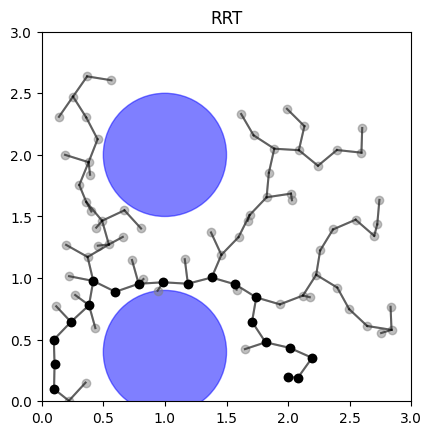

init tree
DIM: -1
runtime_dim: 2
Options
max_num_trials_col_free = 1000
max_num_configs = 10000
max_compute_time_ms = 1e+09
max_step = 0.2
collision_resolution = 0.01
goal_tolerance = 0.001
goal_bias = 0.05
backward_probability = 0.5
max_it = 10000

Terminate status: GOAL_REACHED
num_it: 57
configs.size(): 7
configs_backwared.size(): 31
compute time (ms): 3
collisions time (ms): 3.49734
evaluated_edges: 87
infeasible_edges: 0
path.size(): 19
total_distance: 3.49923
Message in plan (/home/quim/code/dynoRRT/include/dynoRRT/lazyprm.h:66) --Options
k_near = 10
max_num_trials_col_free = 1000
max_compute_time_ms = 1e+09
connection_radius = 0.5
max_lazy_iterations = 1000
collision_resolution = 0.01
increase_vertices_rate = 2.0
num_vertices_0 = 20

time build tree 0
time_nn: 0.004
Message in plan (/home/quim/code/dynoRRT/include/dynoRRT/lazyprm.h:176) --graph built!
path id is 
0 1 Path not valid -- Running again
path id is 
0 8 1 Path not valid -- Running again
path id is 
0 3 8 1 Path not va

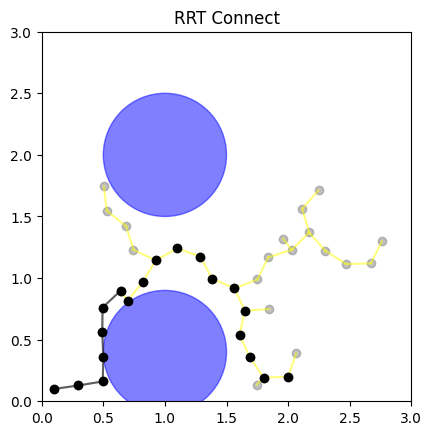

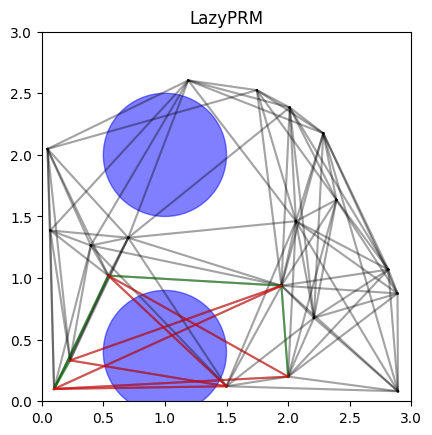

In [19]:
# In these four examples, we have computed collisions using Pinocchio and URDF.
# Can I use my own collision checker? - Yes!
# For fast prototyping, you can define the collision function in Python directly.
# The collision function can even call a compiled function -- then 
# you will only have the overhead of calling a Python function. In my experience, using collision models with approximate shapes, this may double/triple the time with respect to a pure C++ implementation.

# For example, let's solve a 2D problem, where obstacles are circles
# and our robot is a point.

xlim = [0, 3]
ylim = [0, 3]

class Obstacle:
    def __init__(self, center: np.ndarray, radius: float):
        self.center = center
        self.radius = radius


obstacles = [Obstacle(center=np.array([1, 0.4]), radius=0.5),
             Obstacle(center=np.array([1, 2]), radius=0.5)]


def is_collision_free(x: np.ndarray) -> bool:
    """
    x: 2D vector (x, y)

    """
    for obs in obstacles:
        if np.linalg.norm(x - obs.center) < obs.radius:
            return False
    return True


def plot_env(ax, obstacles):
    for obstacle in obstacles:
        ax.add_patch(plt.Circle(
            (obstacle.center), obstacle.radius, color="blue", alpha=0.5))


def plot_robot(ax, x, color="black", alpha=1.0):
    ax.plot([x[0]], [x[1]], marker="o", color=color, alpha=alpha)


fig, ax = plt.subplots()
start = np.array([0.1, 0.1])
goal = np.array([2.0, 0.2])
plot_env(ax, obstacles)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect("equal")
ax.set_title("RRT")


rrt = pyrrt.PlannerRRT_Rn()
rrt.set_start(start)
rrt.set_goal(goal)
rrt.init(2)
rrt.set_is_collision_free_fun(is_collision_free)
rrt.set_bounds_to_state([xlim[0], ylim[0]], [xlim[1], ylim[1]])

options = """
[RRT_options]
max_step = 0.2
"""
rrt.read_cfg_string(options)
out = rrt.plan()

path = rrt.get_path()
fine_path = rrt.get_fine_path(0.05)
configs = rrt.get_configs()
parents = rrt.get_parents()
#
for i, c in enumerate(configs):
    plot_robot(ax, c, color="gray", alpha=0.5)
    if parents[i] != -1:
        plt.plot([c[0], configs[parents[i]][0]], [
                 c[1], configs[parents[i]][1]], color="gray", alpha=0.5)


for i in range(len(path)):
    plot_robot(ax, path[i], color="black")

for i, p in enumerate(parents):
    if p != -1:
        ax.plot(
            [configs[i][0], configs[p][0]],
            [configs[i][1], configs[p][1]],
            color="black",
            alpha=0.5,
        )
plt.show()

# RRT Connect

fig, ax = plt.subplots()
start = np.array([0.1, 0.1])
goal = np.array([2.0, 0.2])
plot_env(ax, obstacles)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect("equal")
ax.set_title("RRT Connect")


rrt = pyrrt.PlannerRRTConnect_Rn()
rrt.set_start(start)
rrt.set_goal(goal)
rrt.init(2)
rrt.set_is_collision_free_fun(is_collision_free)
rrt.set_bounds_to_state([xlim[0], ylim[0]], [xlim[1], ylim[1]])

options = """
[RRTConnect_options]
max_step = 0.2
"""
rrt.read_cfg_string(options)

out = rrt.plan()

planner_data = rrt.get_planner_data()
parents_bwd = planner_data["parents_backward"]
configs_bwd = planner_data["configs_backward"]

path = rrt.get_path()
fine_path = rrt.get_fine_path(0.05)
configs = rrt.get_configs()
parents = rrt.get_parents()
#
for i, c in enumerate(configs):
    plot_robot(ax, c, color="gray", alpha=0.5)
    if parents[i] != -1:
        plt.plot([c[0], configs[parents[i]][0]], [
                 c[1], configs[parents[i]][1]], color="gray", alpha=0.5)
        
for i, c in enumerate(configs_bwd):
    plot_robot(ax, c, color="gray", alpha=0.5)
    if parents_bwd[i] != -1:
        plt.plot([c[0], configs_bwd[parents_bwd[i]][0]], [
                 c[1], configs_bwd[parents_bwd[i]][1]], color="yellow", alpha=0.5)

        

for i in range(len(path)):
    plot_robot(ax, path[i], color="black")

for i, p in enumerate(parents):
    if p != -1:
        ax.plot(
            [configs[i][0], configs[p][0]],
            [configs[i][1], configs[p][1]],
            color="black",
            alpha=0.5,
        )
        
# And finally, PRM*
fig, ax = plt.subplots()
start = np.array([0.1, 0.1])
goal = np.array([2.0, 0.2])
plot_env(ax, obstacles)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect("equal")
ax.set_title("LazyPRM")


rrt = pyrrt.PlannerLazyPRM_Rn()
rrt.set_start(start)
rrt.set_goal(goal)
rrt.init(2)
rrt.set_is_collision_free_fun(is_collision_free)
rrt.set_bounds_to_state([xlim[0], ylim[0]], [xlim[1], ylim[1]])

options = """
[LazyPRM_options]
num_vertices_0 = 20
k_near = 10
"""
rrt.read_cfg_string(options)
out = rrt.plan()

planner_data = rrt.get_planner_data()
adjacency = planner_data["adjacency_list"]
check_edges_valid = planner_data["check_edges_valid"]
check_edges_invalid = planner_data["check_edges_invalid"]

path = rrt.get_path()
fine_path = rrt.get_fine_path(0.05)
configs = rrt.get_configs()
parents = rrt.get_parents()

for i in range(len(adjacency)):
    for j in adjacency[i]:
        ax.plot(
            [configs[i][0], configs[j][0]],
            [configs[i][1], configs[j][1]],
            color="black",
            alpha=0.2)

for i in range(len(check_edges_valid)):
            ax.plot(
                [configs[check_edges_valid[i][0]][0], configs[check_edges_valid[i][1]][0]],
                [configs[check_edges_valid[i][0]][1], configs[check_edges_valid[i][1]][1]],
                color="green",
                alpha=0.5)
        
for i in range(len(check_edges_invalid)):
    ax.plot(
                [configs[check_edges_invalid[i][0]][0], configs[check_edges_invalid[i][1]][0]],
                [configs[check_edges_invalid[i][0]][1], configs[check_edges_invalid[i][1]][1]],
                color="red",
                alpha=0.5,
            )


